<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Performance_Experiments_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Experiments (v1)
This notebook looks into performance considerations. How can we customise models and training algorithms without losing the performance benefits of TensorFlow, GPUs, and the computation graph?

In [3]:
import tensorflow as tf
import numpy as np
import time
import timeit
from datetime import datetime

# Environment specs
This is how you can get a quick summary of the environment.

In [ ]:
from platform import python_version
import torch
import keras
print("Python version", python_version())
print("Pytorch - version", torch.__version__)
print("Pytorch - cuDNN version :", torch.backends.cudnn.version())
print("TensorFlow version", tf.__version__)
print("Keras version", keras.__version__)
# Python version 3.10.12
# Pytorch - version 2.3.0+cu121
# Pytorch - cuDNN version : 8906
# TensorFlow version 2.15.0
# Keras version 2.15.0

Python version 3.10.12
Pytorch - version 2.3.0+cu121
Pytorch - cuDNN version : 8906
TensorFlow version 2.15.0
Keras version 2.15.0


In [ ]:
!pip install gpustat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.3 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26532 sha256=45ebde3cfc22c8ba158b54f2f72f1f116a1651763f4ddcf668e28f1204363066
  Stored in directory: /root/.cache/pip/wheels/ec/d7/80/a71ba3540900e1f276bcae685efd8e590c810d2108b95f1e47
Successfully built gpustat
17a9d7cefc84  Wed Jun 19 07:07:50 2024  535.104.05
[0] Tesla T4 | 58°C,   0 % |   129 / 15360 MB |


In [ ]:
!gpustat

17a9d7cefc84  Wed Jun 19 07:08:24 2024  535.104.05
[0] Tesla T4 | 58°C,   0 % |   129 / 15360 MB |


You can also find out more in Google Colab by clicking on the down-arrow next to the connection info. For example, the following shows that we've got 12.7GB and 15.0GB available for System and GPU RAM, respectively:

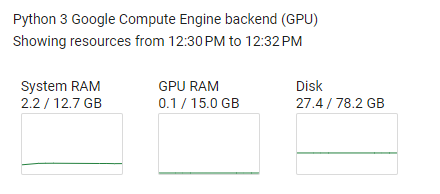

## Hardware Investigations
It turns out that TensorFlow _doesn't_ store everything locally and then transfer to the GPU when it needs to do things. It actually stores the data directly on the GPU.
See: https://www.tensorflow.org/tutorials/customization/basics#gpu_acceleration

But it depends. And thankfully you can find out where a tensor is stored.


In [ ]:
# The output of this depends on what kind of Runtime you're connected to.
# For example...
# CPU:
#  List of physical devices:
#  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
#  Is the Tensor on GPU #0:  False
#  Tensor device: /job:localhost/replica:0/task:0/device:CPU:0
#
# GPU:
#  List of physical devices:
#  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
#   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
#  Is the Tensor on GPU #0:  True
#  Tensor device: /job:localhost/replica:0/task:0/device:GPU:0
#
# TPU:
#  List of physical devices:
#  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
#   PhysicalDevice(name='/physical_device:TPU_SYSTEM:0', device_type='TPU_SYSTEM'),
#   PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'),
#   PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'),
#   PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'),
#   PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'),
#   PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'),
#   PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'),
#   PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'),
#   PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]
#  Is the Tensor on GPU #0:  False
#  Tensor device: /job:localhost/replica:0/task:0/device:CPU:0

x = tf.random.uniform([3, 3])

print("List of physical devices: "),
print(tf.config.list_physical_devices())

print()
print(f"Is the Tensor on GPU #0:  {x.device.endswith('GPU:0')}"),
print(f"Tensor device: {x.device}")

List of physical devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Is the Tensor on GPU #0:  True
Tensor device: /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
# Even data that starts as a NumPy array and is passed to a tensor gets copied into the GPU
ndarray = np.ones([3, 3])
tensor = tf.math.multiply(ndarray, 42)
print(tensor.device)

/job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
# However tensors from Datasets may not and you can't force them either
ds = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])
for row in ds:
  print(row.device)

print()
print("Trying to force it") # see below
with tf.device("GPU:0"):
  ds = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])
  for row in ds:
    print(row.device)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0

Trying to force it
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0


In [ ]:
# TF Variables also have a device property
v = tf.Variable(tf.random.normal((1,2), dtype=tf.float64), name="v")
v.device

'/job:localhost/replica:0/task:0/device:GPU:0'

You can also explicitly control where tensors are created via the device manager. For example:

In [ ]:
# Typical output
#On CPU:
#1000 loops: 2983.85ms (sometimes as much as 20s)
#On GPU:
#1000 loops: 315.55ms
#On TPU:
#1000 loops: 512.95ms (TPUs have more overhead and so need more data to become efficient)

def time_matmul(x):
  start = time.time()
  for loop in range(1000):
    tf.linalg.matmul(x, x)
  result = time.time()-start
  print("1000 loops: {:0.2f}ms".format(1000*result))

# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU #0 if available
if tf.config.list_physical_devices("GPU"):
  print("On GPU:")
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

# Force execution on TPU #0 if available
if tf.config.list_physical_devices("TPU"):
  print("On TPU:")
  with tf.device("TPU:0"):
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("TPU:0")
    time_matmul(x)

On CPU:
1000 loops: 19039.99ms
On GPU:
1000 loops: 315.55ms


It looks like you can also get log information about where data is stored, but I haven't tried it yet:

In [ ]:
tf.debugging.set_log_device_placement(True)

## Understanding Auto-diff
Auto-diff helps with computations of gradients. It can also be used for any other scenarios when you need to calculate differentials. For example, it has a `jacobian()` method that computes full jacobian matrices, and can be used in so called "physics informed" networks.

Docs:
* https://www.tensorflow.org/guide/autodiff
* https://www.tensorflow.org/guide/advanced_autodiff

List of ops that have gradients registered:
* https://www.tensorflow.org/api_docs/python/tf/raw_ops

Some general points (from the autodiff article):
* Avoid use of NumPy operations while within GradientTape
* Be careful to avoid use of ints and strings, as these aren't differentiable
* Be careful not to accidentally convert a tf.Variable to a tf.Tensor when doing things. For example, the following will result in `x` being a Tensor, and then it won't get watched anymore by the gradient tape:

```python
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y = x+1
  x = x + 1   # This should be `x.assign_add(1)`
```
* Apparently stateful objects, including tf.Variable, block gradients. I don't understand the implications of this yet, but here's an example:

```python
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)
```

## Understanding Graph Execution
Graphs go well beyond auto-diff, and apply to the entire execution of a model and its training.

Docs on computation graphs:
* https://www.tensorflow.org/guide/intro_to_graphs
* https://www.tensorflow.org/guide/function
* https://www.tensorflow.org/api_docs/python/tf/function
* https://www.tensorflow.org/guide/graph_optimization
* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/index.md

General docs on performance optimization and performance troubleshooting:
* https://www.tensorflow.org/guide/profiler
* https://www.tensorflow.org/guide/gpu_performance_analysis
* https://openxla.org/xla

Code references:
* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/eager/polymorphic_function/polymorphic_function.py

General description:
* The "intro to graphs" link above provides a really good explanation.
* `tf.Graph` graphs are collections of `tf.Operation` operations that are stored as a data structure, in a program language agnostic way (ie: agnostic of Python). They can actually be run on systems that don't even have a Python interpreter, like mobiles.
* tf operations are directly captured in the graph. Other python commands are converted via [`tf.AutoGraph`](https://www.tensorflow.org/api_docs/python/tf/autograph).
* Relationship between `tf.Function` and `tf.AutoGraph`: `tf.Function` is the high-level API, and uses `tf.AutoGraph` internally. `tf.AutoGraph` is the low-level API, and does not perform some of the high-level functionality such as caching results, or wrapping the result to make it callable.
* TensorFlow uses [Grappler](https://www.tensorflow.org/guide/graph_optimization) to optimize the execution graphs in the same way that a compiler tries to optimise code.
* And of course this graph is easier for TensorFlow to automatically decide how to parallelise and distribute its computation.
* `tf.function` applies to a function and all other functions it calls, including those not marked with `@tf.function`. This works as long as the operations within the called function can be mapped to graph operations.
* Graphs are actually "polymorphic" - containing separately managed graphs for different kinds of inputs (eg: different shapes) to the original python function. These are then separately optimized too.

Notes:
* Use TensorFlow APIs like `tf.data`, `tf.print`, `tf.summary`, `tf.Variable.assign`, and `tf.TensorArray` for everything. Any other python/NumPy operations are useful only for debugging.
* Construct tf.Variables _outside_ of tf.function, because they are created only during tracing (see [tf.function API docs](https://www.tensorflow.org/api_docs/python/tf/function#variables_may_only_be_created_once)).
* Graph execution skips unnecessary operations, so you may not get runtime error checking unless you make it explicit with `tf.debugging`.
* In general, only the most basic python control structures like `if`, `for`, `while`, `break`, `continue` and `return` are compiled into the graph reliably. For everything else, it is better to use tf datatypes.
* You can supply Python datatypes (eg: lists, arrays) provided that they are treated only as constants - however they can cause re-tracing because even the value of a Python variable is taken as part of its definition. Any variables must be TF types, eg: `tf.TensorArray(..., dynamic_size=True)` for an appendable list. (see [tf.function API docs](https://www.tensorflow.org/api_docs/python/tf/function))
* Avoid any references to python variables created outside of the function. Pass everything as arguments and return everything via `return`.
* It's possible to customize handling of Python objects via `__tf_tracing_type__` (see [Rules of tracing](https://www.tensorflow.org/guide/function#rules_of_tracing)).
* It's also possible to blend in eager-executed python functions via `tf.py_function`, but it's inefficient (see [Executing python side effects](https://www.tensorflow.org/guide/function#executing_python_side_effects)).
* It's also possible to force that tf operations only run once during tracing time (as an initialisation), via `tf.init_scope` (see [Changing pypthon variables](https://www.tensorflow.org/guide/function#changing_python_global_and_free_variables)).

Debugging notes:
* Use python print to check for re-tracing.
* Use `tf.print()` to print out intermediate values during execution.
* `tf.debugging.enable_check_numerics` is an easy way to track down where NaNs and Inf are created.
* Use `tf.config.run_functions_eagerly(True)` to force eager execution.

Performance notes:
* The initial trace can take some time, so graph-based execution can be slower on toy examples.
* Use python `print` statements to test for re-tracing.
* It's to be specific about the input signature via `input_signature`, and prefer shapes with `None` to handle variable sizes of input (see [Transformer](https://www.tensorflow.org/text/tutorials/transformer) and [Deep Dream](https://www.tensorflow.org/tutorials/generative/deepdream) tutorials for examples):

```python
@tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),))
def my_func(x):
  ...
```
* You can also pass `reduce_retracing` to automatically graph to more generic types, but this can lead to inefficiencies.

* For faster performance, use `tf.function(jit_compile=True)` which compiles the graph via OpenXLA.

### Auto-Graph conversions
See the AutoGraph reference docs on [Control Flow](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/control_flow.md) for details.

`if`:
* converted to `tf.cond`, but only if the expression evaluates to a Tensor, otherwise it is executed as Python and only during tracing.
* If combined with a python parameter and re-tracing, then you might get the separate branch executions. But you're better off ensuring it's TF compatible.
* `tf.cond` represents a split in the graph, with separate sub-graphs.

loops in general:
* Loops processed as python loops execute only during tracing, unrolling the loop as many iterations as occur.
* Loops that are processed as TensorFlow loops (`tf.while_loop`) are represented in the graph as an explicit loop, and thus can handle dynamic iteration counts.

`for`:
* `for x in y: ...` is mapped to `tf.while_loop` if `y` is a tensor. If it's a Dataset, then it's turned into a series of special Dataset ops.

`while`:
* `while <condition>: ...` is mapped to `tf.while_loop` only if `<condition>` is a tensor.

`iterators`:
* Explicit iterator management (like use of `next(iter)`) won't get converted accurately unless the iterator came from a `tf` datatype (see: [Using python iterations and generators](https://www.tensorflow.org/guide/function#using_python_iterators_and_generators)).



In [ ]:
# A regular python function can be explicitly turned into a graph by passing it to tf.function():

# normal python function (using tf ops)
def a_regular_function(x, y, b):
  x = tf.matmul(x, y)
  x = x + b
  return x

# execute eagerly
x1 = tf.constant([[1.0, 2.0]])
y1 = tf.constant([[2.0], [3.0]])
b1 = tf.constant(4.0)
orig_value = a_regular_function(x1, y1, b1).numpy()

# convert to PolymorphicFunction and run again
a_function_that_uses_a_graph = tf.function(a_regular_function)
tf_function_value = a_function_that_uses_a_graph(x1, y1, b1).numpy()

assert(orig_value == tf_function_value)

In [ ]:
# Alternatively, it can be automatically converted to a graph with a decorator:
@tf.function
def a_second_function(x, y, b):
  x = tf.matmul(x, y)
  x = x + b
  return x

tf_function_value2 = a_second_function(x1, y1, b1).numpy()
assert(orig_value == tf_function_value2)

In [ ]:
type(a_regular_function)

function

In [ ]:
print(f"{a_regular_function}")

<function a_regular_function at 0x7889bf3ce5f0>


In [ ]:
print(f"{a_function_that_uses_a_graph}")

In [ ]:
type(a_function_that_uses_a_graph)

tensorflow.python.eager.polymorphic_function.polymorphic_function.Function

In [ ]:
type(a_second_function)

tensorflow.python.eager.polymorphic_function.polymorphic_function.Function

In [ ]:
# You can get some idea of the graphs by viewing the "graph generating code".
# For this you must pass a straight python function (or obtain the original via .python_function)
print(tf.autograph.to_code(a_regular_function))
# OR
# print(tf.autograph.to_code(a_function_that_uses_a_graph.python_function))

def tf__a_regular_function(x, y, b):
    with ag__.FunctionScope('a_regular_function', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        x = ag__.converted_call(ag__.ld(tf).matmul, (ag__.ld(x), ag__.ld(y)), None, fscope)
        x = ag__.ld(x) + ag__.ld(b)
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [ ]:
# You can get a list of concrete functions that have been generated so far:
x1 = tf.constant([[1.0, 2.0, 3.0]])
y1 = tf.constant([[2.0], [3.0], [4.0]])
b1 = tf.constant([4.0])
a_second_function(x1, y1, b1)

x1 = tf.constant([[1.0, 2.0, 3.0]])
y1 = tf.constant([[2.0], [3.0], [4.0]])
b1 = tf.constant([4.0, 5.0, 6.0])
a_second_function(x1, y1, b1)

print(a_second_function.pretty_printed_concrete_signatures())

Input Parameters:
  x (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 2), dtype=tf.float32, name=None)
  y (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(2, 1), dtype=tf.float32, name=None)
  b (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(1, 1), dtype=tf.float32, name=None)
Captures:
  None

Input Parameters:
  x (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
  y (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(3, 1), dtype=tf.float32, name=None)
  b (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(3,), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
Captures:
  None

Input Parameters:
  x (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
  y (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(3, 1), dtype=tf.float32, name=None)
  b (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1,), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(

In [ ]:
# You can identify a specific concrete function by supplying inputs with the right shapes,
# or by supplying a TypeSpec.
# You can even execute that function.
x1 = tf.constant([[1.0, 2.0, 3.0]])
y1 = tf.constant([[2.0], [3.0], [4.0]])
b1 = tf.constant([4.0, 5.0, 6.0])

# The following two lines produce the same result
concrete_fn = a_second_function.get_concrete_function(tf.TensorSpec(shape=[1,3], dtype=tf.float32),
                                                      tf.TensorSpec(shape=[3,1], dtype=tf.float32),
                                                      tf.TensorSpec(shape=[3,], dtype=tf.float32))
concrete_fn = a_second_function.get_concrete_function(x1, y1, b1)
print(f"Concrete function: {concrete_fn}")
print(f"result: {concrete_fn(x1, y1, b1)}")

Concrete function: ConcreteFunction Input Parameters:
  x (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
  y (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(3, 1), dtype=tf.float32, name=None)
  b (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(3,), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
Captures:
  None
result: [[24. 25. 26.]]


In [ ]:
# The `function_type` attribute will print the same information more explicitly

In [ ]:
a_second_function.function_type

Input Parameters:
  x (POSITIONAL_OR_KEYWORD): None
  y (POSITIONAL_OR_KEYWORD): None
  b (POSITIONAL_OR_KEYWORD): None
Output Type:
  None
Captures:
  None

In [ ]:
a_second_function.get_concrete_function(x1, y1, b1).function_type

Input Parameters:
  x (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
  y (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(3, 1), dtype=tf.float32, name=None)
  b (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(3,), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
Captures:
  None

In [ ]:
# And you can then get the actual graph from that concrete function
a_second_function.get_concrete_function(x1, y1, b1).graph.as_graph_def()

node {
  name: "x"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "x"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 1
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "y"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "y"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 3
        }
        dim {
          size: 1
        }
      }
    }
  }
}
node {
  name: "b"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "b"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "MatMul

In [ ]:
# Or for a more streamlined output:
graph = a_second_function.get_concrete_function(x1, y1, b1).graph
for node in graph.as_graph_def().node:
  print(f'{node.input} -> {node.name}')

[] -> x
[] -> y
[] -> b
['x', 'y'] -> MatMul
['MatMul', 'b'] -> add
['add'] -> Identity


It's possible to force eager execution when you need to.
For example:

In [ ]:
@tf.function
def get_MSE(y_true, y_pred):
  print("Calculating MSE!")
  sq_diff = tf.pow(y_true - y_pred, 2)
  return tf.reduce_mean(sq_diff)

print("With default graph execution enabled (runs print only when first traced):")
y_true = tf.random.uniform([5], maxval=10, dtype=tf.int32)
y_pred = tf.random.uniform([5], maxval=10, dtype=tf.int32)
get_MSE(y_true, y_pred)
get_MSE(y_true, y_pred)
get_MSE(y_true, y_pred)

print("With eager execution forced (calls print each time):")
tf.config.run_functions_eagerly(True)
y_true = tf.random.uniform([5], maxval=10, dtype=tf.int32)
y_pred = tf.random.uniform([5], maxval=10, dtype=tf.int32)
get_MSE(y_true, y_pred)
get_MSE(y_true, y_pred)
get_MSE(y_true, y_pred)
tf.config.run_functions_eagerly(False)


With eager execution enabled (runs print only when first traced):
Calculating MSE!
With eager execution forced (calls print each time):
Calculating MSE!
Calculating MSE!
Calculating MSE!


Notice that python parameters get converted to literal values. This explains why python parameters such as num_epochs can lead to re-tracing:

In [ ]:
@tf.function
def pow(a, b):
  return a ** b

square = pow.get_concrete_function(a=tf.TensorSpec(None, tf.float32), b=2)
print(square)

ConcreteFunction Input Parameters:
  a (POSITIONAL_OR_KEYWORD): TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)
  b (POSITIONAL_OR_KEYWORD): Literal[2]
Output Type:
  TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)
Captures:
  None


### Doing the right thing

In [4]:
# It can be useful to measure graph size.
def print_graph_size(f, *args):
  g = f.get_concrete_function(*args).graph
  size = len(g.as_graph_def().node)
  print("{}({}) contains {} nodes in its graph".format(f.__name__, ', '.join(map(str, args)), size))

For example, when writing loops, it can be useful to compare the graph size with different types of arguments. And to use that to avoid problems caused by using Python data types.

In [5]:
@tf.function
def train(dataset):
  loss = tf.constant(0)
  for x, y in dataset:
    loss += tf.abs(y - x) # Some dummy computation.
  return loss

small_data = [(1, 1)] * 3
big_data = [(1, 1)] * 10

print_graph_size(train, small_data)
print_graph_size(train, big_data)
print_graph_size(train, tf.data.Dataset.from_generator(lambda: small_data, (tf.int32, tf.int32)))
print_graph_size(train, tf.data.Dataset.from_generator(lambda: big_data, (tf.int32, tf.int32)))

train([(1, 1), (1, 1), (1, 1)]) contains 11 nodes in its graph
train([(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]) contains 32 nodes in its graph
train(<_FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>) contains 6 nodes in its graph
train(<_FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>) contains 6 nodes in its graph


When accumulating data in a list data structure, use `tf.TensorArray`.

In [ ]:
@tf.function
def train(rnn_step, input_data, initial_state):
  max_seq_len = input_data.shape[0]

  states = tf.TensorArray(tf.float32, size=max_seq_len)
  state = initial_state
  for i in tf.range(max_seq_len):
    state = train_step(input_data[i], state)
    states = states.write(i, state)
  return states.stack()

## Data source Performance Concerns
* When wrapping Python/NumPy data in a Dataset, be mindful of tf.data.Dataset.from_generator versus tf.data.Dataset.from_tensor_slices. The former will keep the data in Python and fetch it via tf.py_function which can have performance implications, whereas the latter will bundle a copy of the data as one large tf.constant() node in the graph, which can have memory implications.
* Reading data from files via TFRecordDataset, CsvDataset, etc. is the most effective way to consume data, as then TensorFlow itself can manage the asynchronous loading and prefetching of data, without having to involve Python. To learn more, see the tf.data: Build TensorFlow input pipelines guide.

For more details, see:
* https://www.tensorflow.org/guide/data